In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

random.seed(123)
np.random

def initial_spins(L):
    return np.random.choice([1, -1], size=(L, L, L))


def calculate_energy(spins, K, h, L):
    energy = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                energy -= h*spins[i, j, k]
                energy -= K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L])
    return energy


def calculate_M(spins):
    M = 0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                M += spins[i, j, k]
    return M


def calculate_C(spins, T, K, h, L):
    # 1/T^2 (<E^2> - <E>^2)
    E = calculate_energy(spins, K, h, L)
    E_squared = calculate_energy(np.square(spins), K, h, L)
    C = T**(-2)*(E_squared - E**2)
    return C


def calculate_sus(spins, T):
    # 1/T (<M^2> - <M>^2)
    M = calculate_M(spins)
    M_squared = calculate_M(np.square(spins))
    sus = T**(-1)*(M_squared - M**2)
    return sus


def calculate_correlation_length(spins):
    # TODO
    corr_len = 0
    return corr_len



In [90]:
def metropolis_algorithim(spins, T, K, h, L):
    # compute beta
    beta = 1/T
    
    #making a trial flip
    i, j, k = np.random.randint(0, L, size=3)
    site = spins[i, j, k]
    trial_flip = site * -1
    trial_flip_spins = spins.copy()
    trial_flip_spins[i, j, k] = trial_flip

    #calculating old energy
    old_energy = -h*spins[i, j, k] - K*(spins[(i+1)%L, j, k] + spins[i, (j+1)%L, k] + spins[i, j, (k+1)%L] +
                                     spins[(i - 1) % L, j, k] +  spins[i, (j-1)%L, k] + spins[i, j, (k-1)%L])
    #calculating new energy
    new_energy = -h*trial_flip_spins[i, j, k] - K*(trial_flip_spins[(i+1)%L, j, k] + trial_flip_spins[i, (j+1)%L, k] + trial_flip_spins[i, j, (k+1)%L] +
                                     trial_flip_spins[(i - 1) % L, j, k] +  trial_flip_spins[i, (j-1)%L, k] + trial_flip_spins[i, j, (k-1)%L])
    #computing delta E and deciding if we should accept the change
    delta_energy = new_energy - old_energy
    if delta_energy < 0:
        spins[i, j, k] = trial_flip
    else:
        w = np.exp(-beta*delta_energy)
        r = random.random()
        if r <= w:
            spins[i, j, k] = trial_flip
    return(spins)

def monte_carlo(T, K, h, L, steps, spins):
    energies = [calculate_energy(spins, K, h, L)]
    magnetizations = [calculate_M(spins)]
    specific_heats = [calculate_C(spins, T, K, h, L)]
    susceptibilities = [calculate_sus(spins, T)]
    correlations = [calculate_correlation_length(spins)]
    for step in range(steps):
        spins = metropolis_algorithim(spins, T, K, h, L)
        if step % 100 == 0 or step == steps-1:
            energies.append(calculate_energy(spins, K, h, L))
            magnetizations.append(calculate_M(spins))
            specific_heats.append(calculate_C(spins, T, K, h, L))
            susceptibilities.append(calculate_sus(spins, T))
            correlations.append(calculate_correlation_length(spins))
    return spins, (energies, magnetizations, specific_heats, susceptibilities, correlations)

In [91]:
def scatter_3D(data, ax, title):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]
    z = np.indices(data.shape)[2]
    col = data.flatten()
    
    # 3D Plot
    p3d = ax.scatter(x, y, z, c=col, cmap="PiYG", vmin=-1, vmax=1)
    ax.grid(False)
    plt.colorbar(p3d, label="Spin")
    ax.set_title(title)
    return

In [92]:
def normalize(array):
    normalized_array = array.copy()
    max = np.max(array)
    min = np.min(array)
    for i in range(len(array)):
        normalized_array[i] = (array[i] - min)/(max-min)
    return normalized_array

def difference(array):
    differences = array.copy()[:-1]
    for i in range(len(array)-1):
        differences[i] = array[i+1] - array[i]
    return differences

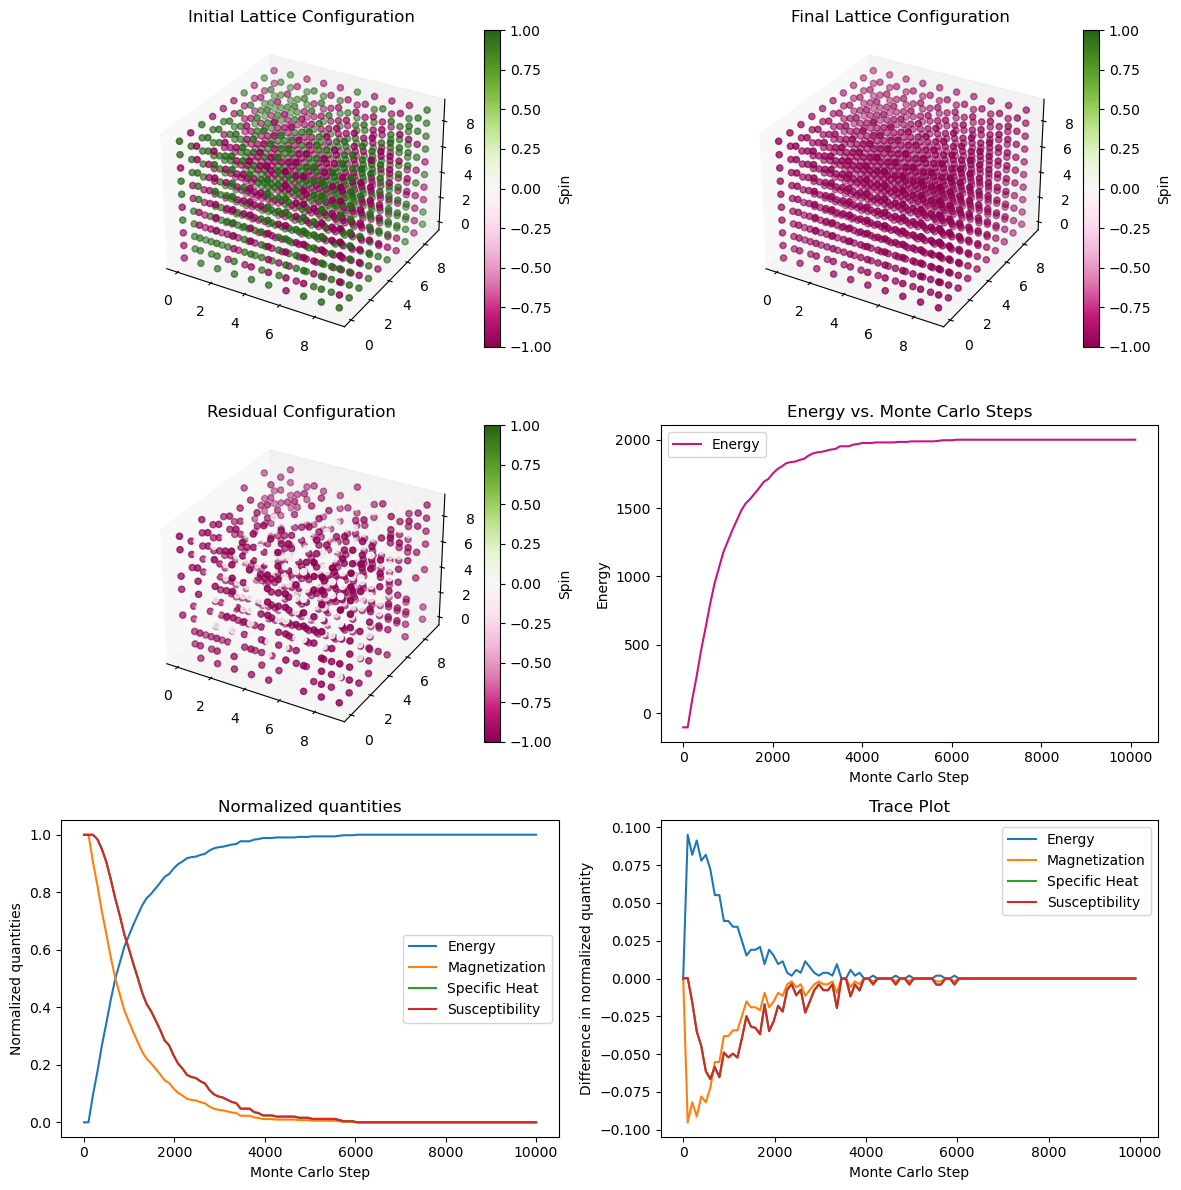

In [93]:
T = 10**(-5)
K = 1
h = -1
L = 10
steps = 10000 #10000
spins_initial = initial_spins(L)
copy_of_spins_initial = spins_initial.copy()
final_spins, quantities = monte_carlo(T, K, h, L, steps, spins_initial)

# Visualization
cmap = "PiYG"
fig = plt.figure(figsize=(12, 12))

ax0 = fig.add_subplot(3, 2, 1, projection='3d')
scatter_3D(copy_of_spins_initial, ax0, "Initial Lattice Configuration")

ax1 = plt.subplot(3, 2, 2, projection='3d')
scatter_3D(final_spins, ax1, "Final Lattice Configuration")

ax2 = plt.subplot(3, 2, 3, projection='3d')
scatter_3D(final_spins - copy_of_spins_initial, ax2, "Residual Configuration")

energies = quantities[0]
plt.subplot(3, 2, 4)
plt.title("Energy vs. Monte Carlo Steps")
plt.plot(range(0, len(energies) * 100, 100), energies, label="Energy", color='mediumvioletred')
plt.xlabel("Monte Carlo Step")
plt.ylabel("Energy")
plt.legend()

plt.subplot(3, 2, 5)
plt.title("Normalized quantities")
xs = np.linspace(0, steps, len(quantities[0]))
plt.plot(xs, normalize(quantities[0]), label="Energy")
plt.plot(xs, normalize(quantities[1]), label="Magnetization")
plt.plot(xs, normalize(quantities[2]), label="Specific Heat")
plt.plot(xs, normalize(quantities[3]), label="Susceptibility")
# plt.plot(xs, normalize(quantities[4]), label="Correlation Length")  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Normalized quantities")
plt.legend()

plt.subplot(3, 2, 6)
plt.title("Trace Plot")
plt.plot(xs[:-1], difference(normalize(quantities[0])), label="Energy")
plt.plot(xs[:-1], difference(normalize(quantities[1])), label="Magnetization")
plt.plot(xs[:-1], difference(normalize(quantities[2])), label="Specific Heat")
plt.plot(xs[:-1], difference(normalize(quantities[3])), label="Susceptibility")
# plt.plot(xs[:-1], difference(quantities[4]), label="Correlation Length")  # TODO
plt.xlabel("Monte Carlo Step")
plt.ylabel("Difference in normalized quantity")
plt.legend()

plt.tight_layout()
plt.show()
plt.close()

100%|███████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


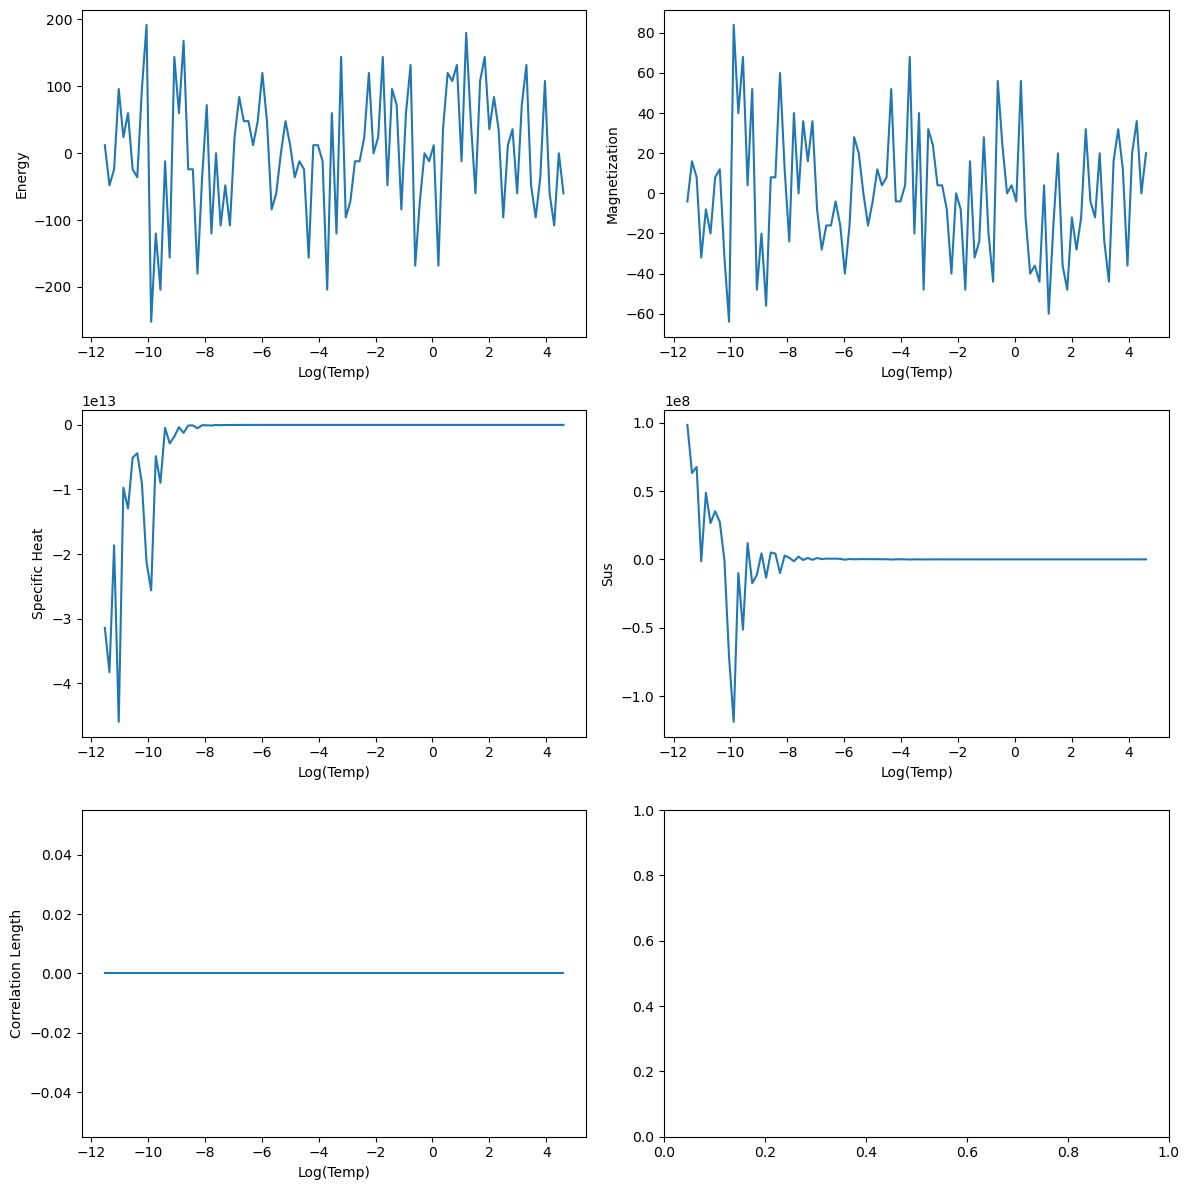

In [97]:
aligned_spins = final_spins.copy()
temps = np.logspace(-5, 2, 100)
final_Es = []
final_Ms = []
final_Cs = []
final_chis = []
final_xis = []

# turn off external magnetic field
h = 0

for T in tqdm(temps):
    initial_spins = aligned_spins.copy()
    _, quantities = monte_carlo(T, K, h, L, steps, initial_spins)
    final_Es.append(quantities[0][-1])
    final_Ms.append(quantities[1][-1])
    final_Cs.append(quantities[2][-1])
    final_chis.append(quantities[3][-1])
    final_xis.append(quantities[4][-1])

def plot_final_vs_t(temps, final_vals, axs, name):
    axs.plot(np.log(temps), final_vals, label=name)
    axs.set_xlabel("Log(Temp)")
    axs.set_ylabel(name)
    return axs

fig, ax = plt.subplots(3, 2, figsize=(12, 12))

ax[0, 0] = plot_final_vs_t(temps, final_Es, ax[0, 0], "Energy")
ax[0, 1] = plot_final_vs_t(temps, final_Ms, ax[0, 1], "Magnetization")
ax[1, 0] = plot_final_vs_t(temps, final_Cs, ax[1, 0], "Specific Heat")
ax[1, 1] = plot_final_vs_t(temps, final_chis, ax[1, 1], "Sus")
ax[2, 0] = plot_final_vs_t(temps, final_xis, ax[2, 0], "Correlation Length")

plt.tight_layout()
plt.show()
plt.close()